В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Числові колонки: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Категоріальні колонки: ['Geography', 'Gender']
=== Результати на тренувальних даних ===
Area under ROC score on Training dataset: 0.88


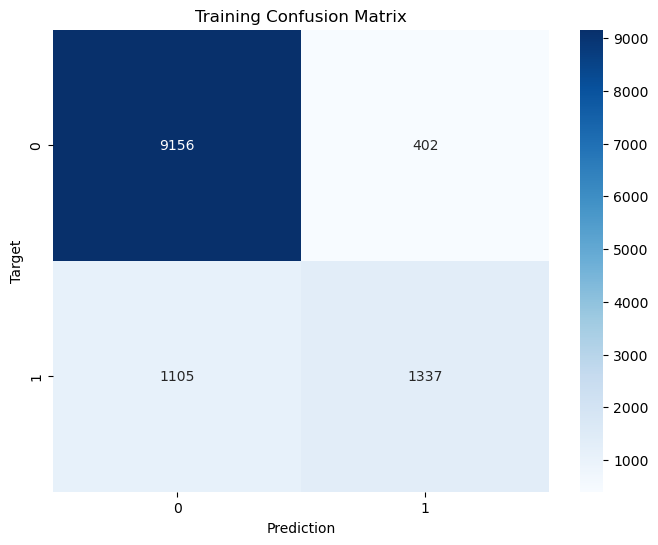


=== Результати на валідаційних даних ===
Area under ROC score on Validation dataset: 0.88


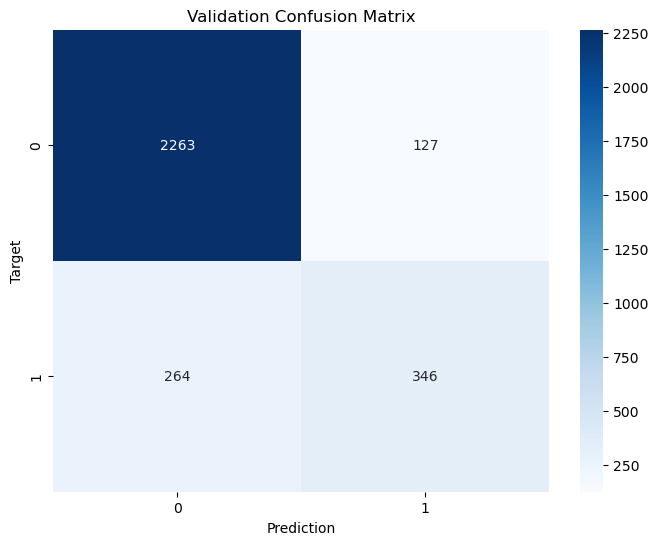


Модель збережена як 'logistic_regression_pipeline.pkl'

Розмір тренувального набору: 12000
Розмір валідаційного набору: 3000
Кількість ознак після препроцесингу: 13


In [13]:
raw_df = pd.read_csv('./kaggle/train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])


input_cols = [col for col in train_df.columns if col not in ['Exited', 'CustomerId', 'Surname']]
target_col = 'Exited'

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]


numeric_cols = train_inputs.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include=['object']).columns.tolist()

print(f"Числові колонки: {numeric_cols}")
print(f"Категоріальні колонки: {categorical_cols}")


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#  Створюємо пайплайн, який спочатку запускає препроцесинг, потім тренує модель
model_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])


model_pipeline.fit(train_inputs, train_targets)

def predict_and_plot(model_pipeline, inputs, targets, name=''):
    """
    Функція для передбачення і візуалізації результатів
    """
    preds = model_pipeline.predict(inputs)
    pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    
    roc_auc = roc_auc_score(targets, pred_proba)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    return preds


print("=== Результати на тренувальних даних ===")
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Training')

print("\n=== Результати на валідаційних даних ===")
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'logistic_regression_pipeline.pkl')
print("\nМодель збережена як 'logistic_regression_pipeline.pkl'")


print(f"\nРозмір тренувального набору: {len(train_inputs)}")
print(f"Розмір валідаційного набору: {len(val_inputs)}")
print(f"Кількість ознак після препроцесингу: {model_pipeline.named_steps['preprocessor'].transform(train_inputs).shape[1]}")


# loaded_model = joblib.load('logistic_regression_pipeline.pkl')
# predictions = loaded_model.predict(new_data)

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Тренування моделі з polynomial features...

Кількість ознак (базова модель): 13
Кількість ознак (з polynomial features): 49

РЕЗУЛЬТАТИ БАЗОВОЇ МОДЕЛІ
=== Тренувальні дані ===
Area under ROC score on Training (Base) dataset: 0.8825


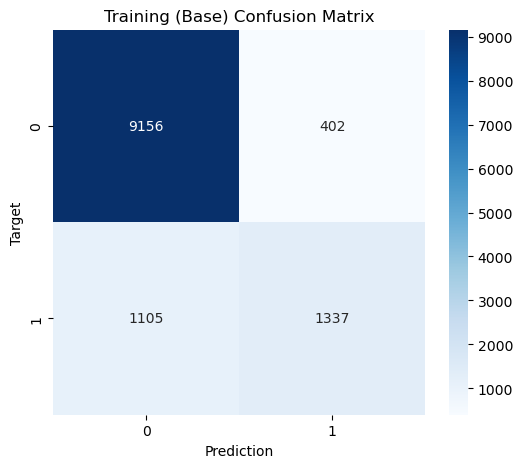


=== Валідаційні дані ===
Area under ROC score on Validation (Base) dataset: 0.8797


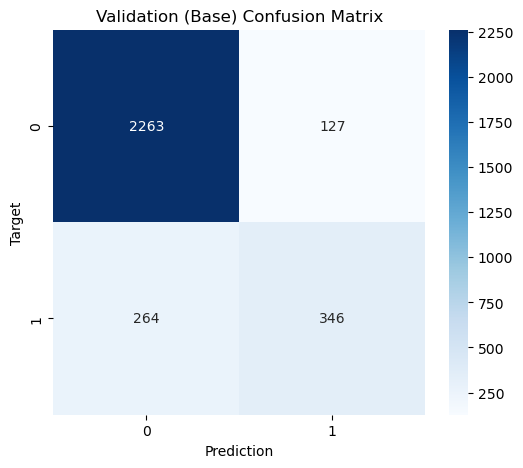


РЕЗУЛЬТАТИ МОДЕЛІ З POLYNOMIAL FEATURES
=== Тренувальні дані ===
Area under ROC score on Training (Polynomial) dataset: 0.9303


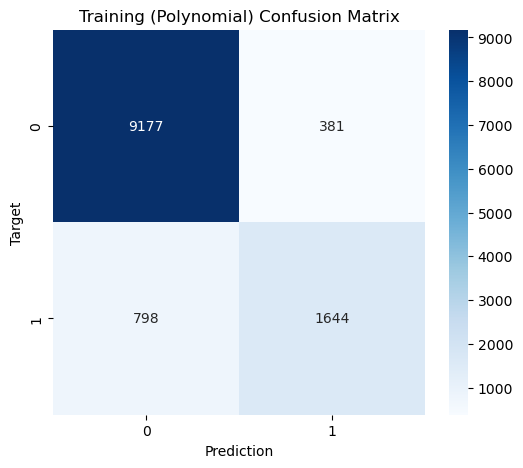


=== Валідаційні дані ===
Area under ROC score on Validation (Polynomial) dataset: 0.9275


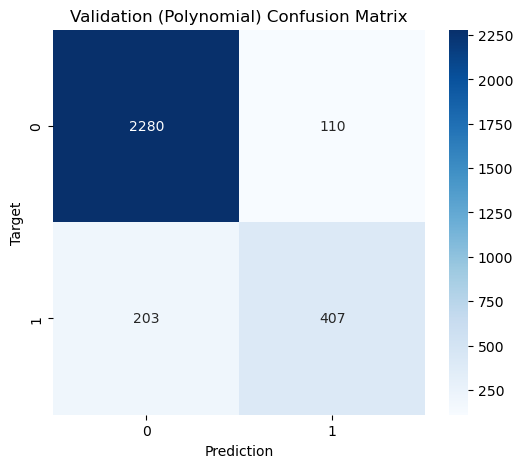


ПОРІВНЯННЯ ТА АНАЛІЗ РЕЗУЛЬТАТІВ
Базова модель:
  Train AUC: 0.8825
  Val AUC:   0.8797
  Різниця:   0.0029

Модель з Polynomial Features:
  Train AUC: 0.9303
  Val AUC:   0.9275
  Різниця:   0.0028

 Краща модель збережена як 'best_model_polynomial.pkl'


In [19]:
def evaluate_model(model_pipeline, inputs, targets, name=''):
    """Функція для оцінки моделі та виведення результатів"""
    preds = model_pipeline.predict(inputs)
    pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    
    roc_auc = roc_auc_score(targets, pred_proba)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}")
    
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    return roc_auc

numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])


preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)  
    ])


model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

print("Тренування моделі з polynomial features...")
model_pipeline_poly.fit(train_inputs, train_targets)

model_pipeline_base = model_pipeline

print(f"\nКількість ознак (базова модель): {model_pipeline_base.named_steps['preprocessor'].transform(train_inputs).shape[1]}")
print(f"Кількість ознак (з polynomial features): {model_pipeline_poly.named_steps['preprocessor'].transform(train_inputs).shape[1]}")

print("\n" + "="*50)
print("РЕЗУЛЬТАТИ БАЗОВОЇ МОДЕЛІ")
print("="*50)

print("=== Тренувальні дані ===")
train_auc_base = evaluate_model(model_pipeline_base, train_inputs, train_targets, name='Training (Base)')

print("\n=== Валідаційні дані ===")
val_auc_base = evaluate_model(model_pipeline_base, val_inputs, val_targets, name='Validation (Base)')

print("\n" + "="*50)
print("РЕЗУЛЬТАТИ МОДЕЛІ З POLYNOMIAL FEATURES")
print("="*50)

print("=== Тренувальні дані ===")
train_auc_poly = evaluate_model(model_pipeline_poly, train_inputs, train_targets, name='Training (Polynomial)')

print("\n=== Валідаційні дані ===")
val_auc_poly = evaluate_model(model_pipeline_poly, val_inputs, val_targets, name='Validation (Polynomial)')

# АНАЛІЗ РЕЗУЛЬТАТІВ

print("\n" + "="*60)
print("ПОРІВНЯННЯ ТА АНАЛІЗ РЕЗУЛЬТАТІВ")
print("="*60)

print("Базова модель:")
print(f"  Train AUC: {train_auc_base:.4f}")
print(f"  Val AUC:   {val_auc_base:.4f}")
print(f"  Різниця:   {train_auc_base - val_auc_base:.4f}")

print("\nМодель з Polynomial Features:")
print(f"  Train AUC: {train_auc_poly:.4f}")
print(f"  Val AUC:   {val_auc_poly:.4f}")
print(f"  Різниця:   {train_auc_poly - val_auc_poly:.4f}")

# Аналіз overfit/underfit
diff_base = train_auc_base - val_auc_base
diff_poly = train_auc_poly - val_auc_poly

# Збереження кращої моделі
joblib.dump(best_model, f'best_model_{model_name}.pkl')
print(f"\n Краща модель збережена як 'best_model_{model_name}.pkl'")

### ВИСНОВКИ ПРО МОДЕЛЬ З POLYNOMIAL FEATURES:
 
 - Покращення на валідації: +0.0479
 - Зміна gap (train-val): -0.0001  
 - СХОЖА ГЕНЕРАЛІЗАЦІЯ: Суттєвих змін у генералізації немає  
 - ПОКРАЩЕННЯ: Polynomial features значно покращили якість

 ПІДСУМОК:
   - Якість на валідації: Значне покращення
   - Генералізація: Схожі властивості генералізації
   - Кількість ознак збільшилась з 13 до 49
   - РЕКОМЕНДАЦІЯ: Використовувати модель з polynomial features

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

СТВОРЕННЯ МОДЕЛІ З ПОЛІНОМІАЛЬНИМИ ОЗНАКАМИ СТЕПЕНІ 4
Тренування моделі з polynomial features степені 4...
 Модель успішно натренована!

 ПОРІВНЯННЯ КІЛЬКОСТІ ОЗНАК:
   - Базова модель: 13
   - Polynomial степені 2: 49
   - Polynomial степені 4: 499

РЕЗУЛЬТАТИ МОДЕЛІ З POLYNOMIAL FEATURES СТЕПЕНІ 4
=== Тренувальні дані ===
Area under ROC score on Training (Polynomial Degree 4) dataset: 0.9394


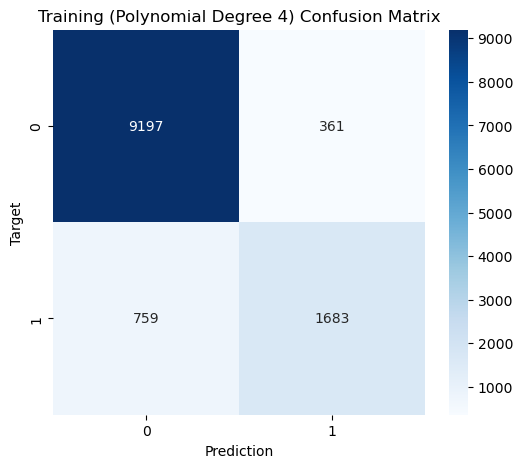


=== Валідаційні дані ===
Area under ROC score on Validation (Polynomial Degree 4) dataset: 0.9323


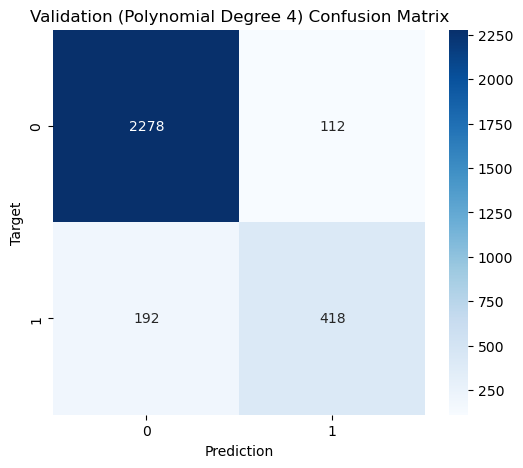


ПОРІВНЯННЯ ВСІХ МОДЕЛЕЙ
                Модель  Train AUC  Val AUC  Gap (Train-Val)  Кількість ознак
                Базова     0.8825   0.8797           0.0029               13
Polynomial (степінь 2)     0.9303   0.9275           0.0028               49
Polynomial (степінь 4)     0.9394   0.9323           0.0070              499

 Фінальна модель збережена як 'final_model_poly4.pkl'


In [20]:
print("="*70)
print("СТВОРЕННЯ МОДЕЛІ З ПОЛІНОМІАЛЬНИМИ ОЗНАКАМИ СТЕПЕНІ 4")
print("="*70)

numeric_transformer_poly4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(random_state=42, max_iter=5000))  # Збільшуємо max_iter
])

print("Тренування моделі з polynomial features степені 4...")

try:
    model_pipeline_poly4.fit(train_inputs, train_targets)
    print(" Модель успішно натренована!")
except Exception as e:
    print(f" Помилка при тренуванні: {e}")
    
print(f"\n ПОРІВНЯННЯ КІЛЬКОСТІ ОЗНАК:")
print(f"   - Базова модель: {model_pipeline_base.named_steps['preprocessor'].transform(train_inputs).shape[1]}")
print(f"   - Polynomial степені 2: {model_pipeline_poly.named_steps['preprocessor'].transform(train_inputs).shape[1]}")
print(f"   - Polynomial степені 4: {model_pipeline_poly4.named_steps['preprocessor'].transform(train_inputs).shape[1]}")


# ОЦІНКА МОДЕЛІ З ПОЛІНОМІАЛЬНИМИ ОЗНАКАМИ СТЕПЕНІ 4

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ МОДЕЛІ З POLYNOMIAL FEATURES СТЕПЕНІ 4")
print("="*60)

print("=== Тренувальні дані ===")
train_auc_poly4 = evaluate_model(model_pipeline_poly4, train_inputs, train_targets, name='Training (Polynomial Degree 4)')

print("\n=== Валідаційні дані ===")
val_auc_poly4 = evaluate_model(model_pipeline_poly4, val_inputs, val_targets, name='Validation (Polynomial Degree 4)')

print("\n" + "="*70)
print("ПОРІВНЯННЯ ВСІХ МОДЕЛЕЙ")
print("="*70)

results_data = {
    'Модель': ['Базова', 'Polynomial (степінь 2)', 'Polynomial (степінь 4)'],
    'Train AUC': [train_auc_base, train_auc_poly, train_auc_poly4],
    'Val AUC': [val_auc_base, val_auc_poly, val_auc_poly4],
    'Gap (Train-Val)': [
        train_auc_base - val_auc_base,
        train_auc_poly - val_auc_poly,
        train_auc_poly4 - val_auc_poly4
    ],
    'Кількість ознак': [
        model_pipeline_base.named_steps['preprocessor'].transform(train_inputs).shape[1],
        model_pipeline_poly.named_steps['preprocessor'].transform(train_inputs).shape[1],
        model_pipeline_poly4.named_steps['preprocessor'].transform(train_inputs).shape[1]
    ]
}

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False, float_format='%.4f'))


# Збереження фінальної моделі
joblib.dump(final_model, f'final_model_{final_model_name}.pkl')
print(f"\n Фінальна модель збережена як 'final_model_{final_model_name}.pkl'")

### ФІНАЛЬНІ ВИСНОВКИ

РЕЙТИНГ МОДЕЛЕЙ ЗА ВАЛІДАЦІЙНИМ AUC:  
   1. Polynomial (степінь 4): 0.9323 (gap: 0.0070)
   2. Polynomial (степінь 2): 0.9275 (gap: 0.0028)
   3. Базова: 0.8797 (gap: 0.0029)

РЕКОМЕНДАЦІЯ:  
    Для submission рекомендується: poly4 (найкращий AUC + прийнятна генералізація)

ПІДСУМОК ЕКСПЕРИМЕНТУ:  
   - Базова модель: стабільна, але може не вловлювати складні залежності  
   - Polynomial степені 2: баланс між складністю і генералізацією  
   - Polynomial степені 4: максимальна складність, ризик overfitting  
   - Кількість ознак зросла з 13 до 499  


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("="*70)
print("АНАЛІЗ РЕГРЕСІЙНИХ ДАНИХ З ПОЛІНОМІАЛЬНИМИ ОЗНАКАМИ")
print("="*70)

df = pd.read_csv('regression_data.csv')
print(df.shape)
print(list(df.columns))
print(f"Типи даних: {df.dtypes}")

print(f"===ПРОПУЩЕНІ ЗНАЧЕННЯ===")
print(df.isnull().sum())
    
target_col = df.columns[-1]  # Остання колонка як цільова
feature_cols = df.columns[:-1].tolist()  # Всі інші як ознаки

print(f"Таргет: {target_col}")
print(f"Ознаки: {feature_cols}")

X = df[feature_cols]
y = df[target_col]

# Розбиваємо на train/test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Тренувальний набір: {X_train.shape[0]} ")
print(f"Тестовий набір: {X_test.shape[0]} ")
print(f"Кількість ознак: {X_train.shape[1]}")


numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"ЧИСЛОВІ ОЗНАКИ : {numeric_cols}")

print(f"\n" + "="*70)
print("СТВОРЕННЯ МОДЕЛІ З ПОЛІНОМІАЛЬНИМИ ОЗНАКАМИ СТЕПЕНІ 5")
print("="*70)


if len(numeric_cols) > 0:
    if len(categorical_cols) > 0:
        from sklearn.preprocessing import OneHotEncoder
        

        numeric_transformer = Pipeline(steps=[
            ('poly', PolynomialFeatures(degree=5, include_bias=False)),
            ('scaler', StandardScaler())
        ])
        

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_cols)
            ]
        )
    else:
        preprocessor = Pipeline(steps=[
            ('poly', PolynomialFeatures(degree=5, include_bias=False)),
            ('scaler', StandardScaler())
        ])


model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("===Тренування моделі===")

model_pipeline.fit(X_train, y_train)    

X_train_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train)
n_features_after = X_train_transformed.shape[1]

print(f"\nТРАНСФОРМАЦІЯ ОЗНАК:")
print(f"Початкова кількість ознак: {len(feature_cols)}")
print(f"Кількість числових ознак: {len(numeric_cols)}")
print(f"Кількість ознак після поліноміальної трансформації: {n_features_after}")
print(f"Коефіцієнт збільшення: {n_features_after / len(feature_cols):.1f}x")
    

print(f"\n" + "="*70)
print("ОЦІНКА ЯКОСТІ МОДЕЛІ")
print("="*70)

# Функція для обчислення метрик
def evaluate_regression_model(model, X, y, dataset_name):
    """Оцінка регресійної моделі"""
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"\n МЕТРИКИ ДЛЯ {dataset_name.upper()} НАБОРУ:")
    print(f"R^2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mse': mse,
        'predictions': y_pred
    }

train_metrics = evaluate_regression_model(model_pipeline, X_train, y_train, "train")
test_metrics = evaluate_regression_model(model_pipeline, X_test, y_test, "test")

print(f"\n" + "="*70)
print("АНАЛІЗ ГЕНЕРАЛІЗАЦІЇ МОДЕЛІ")
print("="*70)

r2_diff = train_metrics['r2'] - test_metrics['r2']
rmse_ratio = test_metrics['rmse'] / train_metrics['rmse']

print(f" ПОРІВНЯННЯ TRAIN VS TEST:")
print(f"R² на train: {train_metrics['r2']:.4f}")
print(f"R² на test:  {test_metrics['r2']:.4f}")
print(f"Різниця R^2:  {r2_diff:.4f}")
print(f"RMSE на train: {train_metrics['rmse']:.4f}")
print(f"RMSE на test:  {test_metrics['rmse']:.4f}")
print(f"Співвідношення RMSE (test/train): {rmse_ratio:.4f}")


АНАЛІЗ РЕГРЕСІЙНИХ ДАНИХ З ПОЛІНОМІАЛЬНИМИ ОЗНАКАМИ
(129, 6)
['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'target']
Типи даних: feature_1    float64
feature_2    float64
feature_3    float64
feature_4    float64
feature_5    float64
target       float64
dtype: object
===ПРОПУЩЕНІ ЗНАЧЕННЯ===
feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
target       0
dtype: int64
Таргет: target
Ознаки: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
Тренувальний набір: 103 
Тестовий набір: 26 
Кількість ознак: 5
ЧИСЛОВІ ОЗНАКИ : ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

СТВОРЕННЯ МОДЕЛІ З ПОЛІНОМІАЛЬНИМИ ОЗНАКАМИ СТЕПЕНІ 5
===Тренування моделі===

ТРАНСФОРМАЦІЯ ОЗНАК:
Початкова кількість ознак: 5
Кількість числових ознак: 5
Кількість ознак після поліноміальної трансформації: 251
Коефіцієнт збільшення: 50.2x

ОЦІНКА ЯКОСТІ МОДЕЛІ

 МЕТРИКИ ДЛЯ TRAIN НАБОРУ:
R^2 Score: 1.0000
RMSE: 0.0000
MAE: 0.0000
MSE: 0.0000

### ВИСНОВКИ ПРО ЯКІСТЬ ТА ГЕНЕРАЛІЗАЦІЮ МОДЕЛІ

- Якість моделі: Відмінна (R² SCORE ≥0.9, це дуже хороше значення)
- Помірний overfitting: різниця R² = 0.0863 (0.05-0.1). Модель показує ознаки перенавчання
- Стабільність: Нестабільна RMSE test/train = 108926946073372.375 (>1.3)
- Кількість ознак: 5 >> 251

ВИСНОВОК: 

- Модель ЗАДОВІЛЬНА, але потребує ПОКРАЩЕННЯ
- Ймовірно варто зменшити степінь поліному, додати регуляризацію

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

ПОГЛИБЛЕНИЙ АНАЛІЗ РЕГУЛЯРИЗАЦІЇ
1. ВАЛІДАЦІЙНІ КРИВІ ДЛЯ РІЗНИХ ЗНАЧЕНЬ ALPHA


/home/liubov/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.245e+01, tolerance: 1.713e+01
  model = cd_fast.enet_coordinate_descent(
/home/liubov/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.232e+01, tolerance: 1.713e+01
  model = cd_fast.enet_coordinate_descent(
/home/liubov/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4

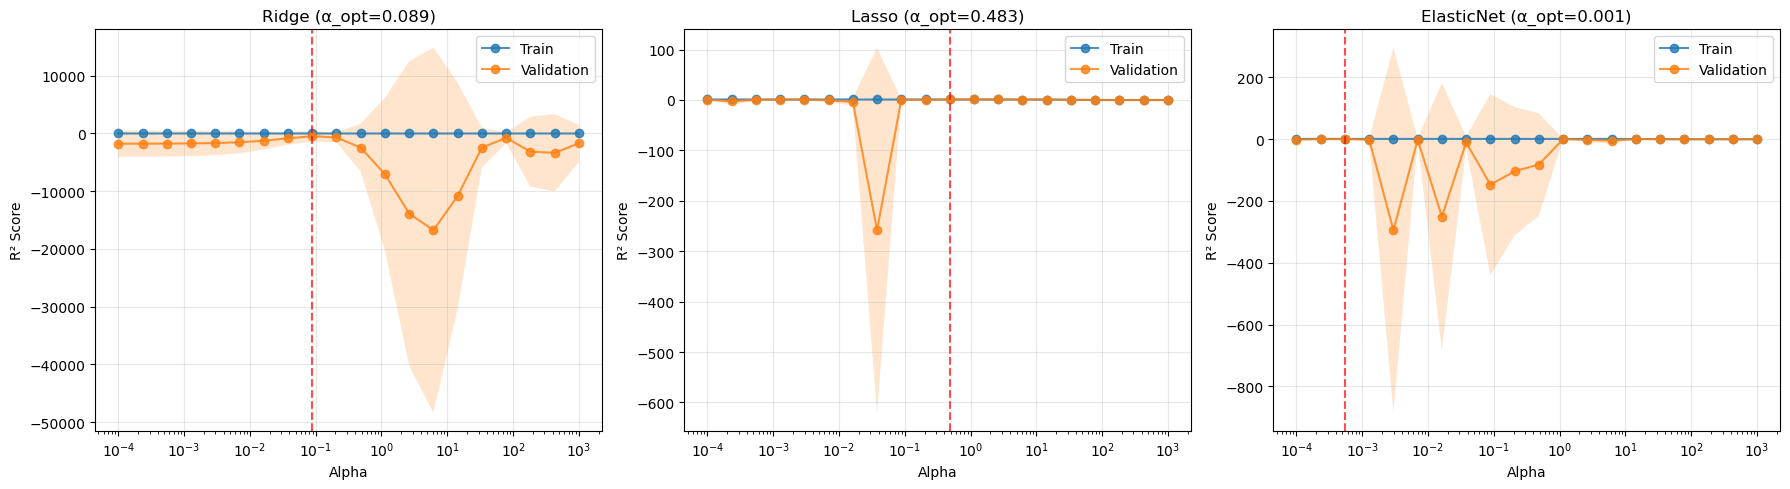


2. АНАЛІЗ ВПЛИВУ СТУПЕНЯ ПОЛІНОМУ


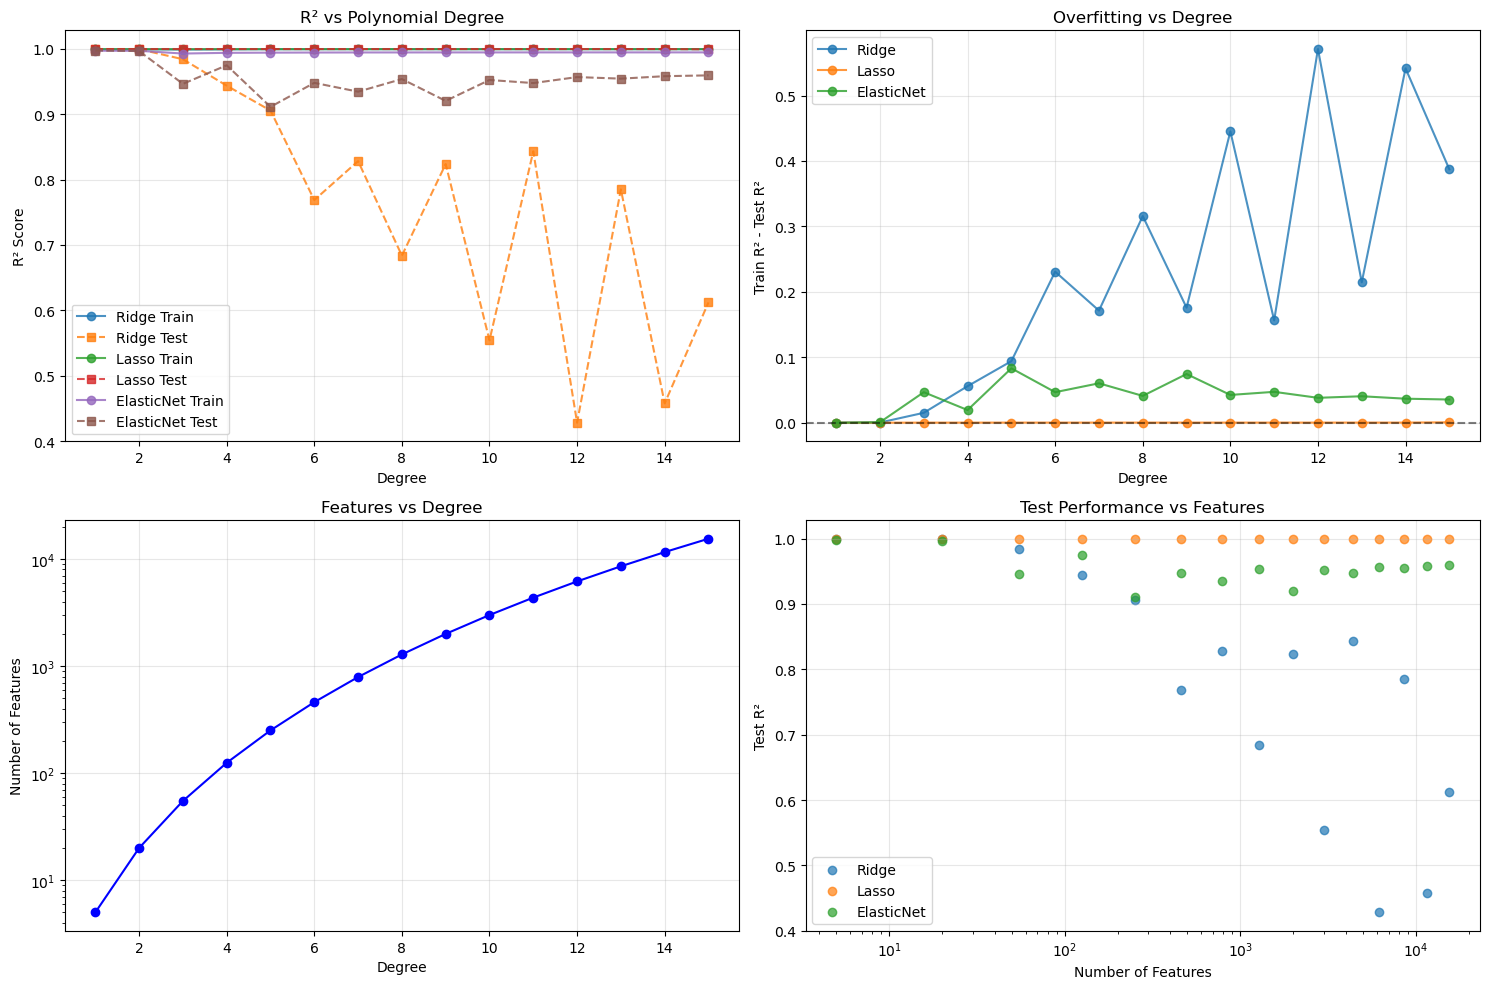


3. АНАЛІЗ КОЕФІЦІЄНТІВ РЕГУЛЯРИЗОВАНИХ МОДЕЛЕЙ


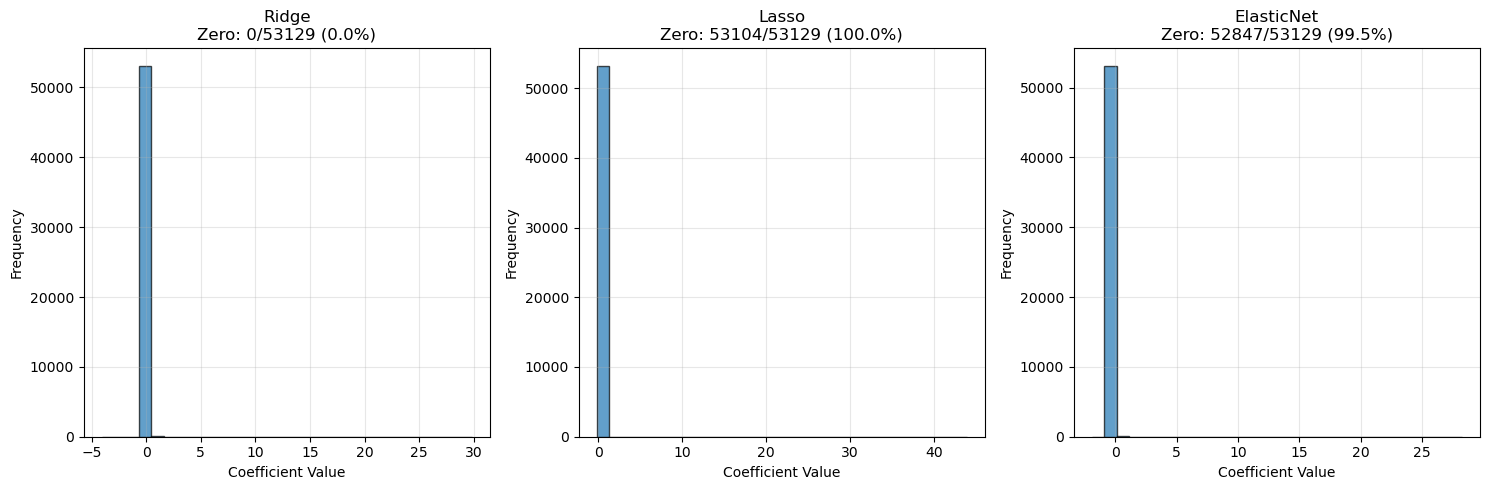

Аналіз завершено!


In [41]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge, Lasso, ElasticNet

print("=" * 80)
print("ПОГЛИБЛЕНИЙ АНАЛІЗ РЕГУЛЯРИЗАЦІЇ")
print("=" * 80)

preprocessor = ColumnTransformer([
    ('num', Pipeline([('poly', PolynomialFeatures(degree=20, include_bias=False)), ('scaler', StandardScaler())]), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
]) if categorical_cols else Pipeline([('poly', PolynomialFeatures(degree=20, include_bias=False)), ('scaler', StandardScaler())])

models = {'Ridge': Ridge(random_state=42), 'Lasso': Lasso(random_state=42, max_iter=2000), 
          'ElasticNet': ElasticNet(random_state=42, max_iter=2000, l1_ratio=0.5)}

# 1. ВАЛІДАЦІЙНІ КРИВІ
print("1. ВАЛІДАЦІЙНІ КРИВІ ДЛЯ РІЗНИХ ЗНАЧЕНЬ ALPHA")
print("=" * 60)

alpha_range = np.logspace(-4, 3, 20)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(models.items()):
    pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
    train_scores, val_scores = validation_curve(pipeline, X_train, y_train, param_name='regressor__alpha', param_range=alpha_range, cv=5, scoring='r2', n_jobs=-1)
    
    train_mean, val_mean = np.mean(train_scores, axis=1), np.mean(val_scores, axis=1)
    best_alpha = alpha_range[np.argmax(val_mean)]
    
    axes[idx].semilogx(alpha_range, train_mean, 'o-', label='Train', alpha=0.8)
    axes[idx].fill_between(alpha_range, train_mean - np.std(train_scores, axis=1), train_mean + np.std(train_scores, axis=1), alpha=0.2)
    axes[idx].semilogx(alpha_range, val_mean, 'o-', label='Validation', alpha=0.8)
    axes[idx].fill_between(alpha_range, val_mean - np.std(val_scores, axis=1), val_mean + np.std(val_scores, axis=1), alpha=0.2)
    axes[idx].axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7)
    axes[idx].set_title(f'{name} (α_opt={best_alpha:.3f})')
    axes[idx].set_xlabel('Alpha')
    axes[idx].set_ylabel('R² Score')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. АНАЛІЗ СТУПЕНІВ ПОЛІНОМУ
print("\n2. АНАЛІЗ ВПЛИВУ СТУПЕНЯ ПОЛІНОМУ")
print("=" * 60)

degrees = range(1, 16)
degree_models = {'Ridge': Ridge(alpha=1.0, random_state=42), 'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=2000),
                 'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=2000)}

results = {name: {'train': [], 'test': [], 'features': []} for name in degree_models}

for degree in degrees:
    current_preprocessor = ColumnTransformer([
        ('num', Pipeline([('poly', PolynomialFeatures(degree=degree, include_bias=False)), ('scaler', StandardScaler())]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]) if categorical_cols else Pipeline([('poly', PolynomialFeatures(degree=degree, include_bias=False)), ('scaler', StandardScaler())])
    
    n_features = current_preprocessor.fit_transform(X_train).shape[1]
    
    for name, model in degree_models.items():
        pipeline = Pipeline([('preprocessor', current_preprocessor), ('regressor', model)])
        pipeline.fit(X_train, y_train)
        results[name]['train'].append(pipeline.score(X_train, y_train))
        results[name]['test'].append(pipeline.score(X_test, y_test))
        results[name]['features'].append(n_features)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² vs Degree
for name in degree_models:
    axes[0,0].plot(degrees, results[name]['train'], 'o-', label=f'{name} Train', alpha=0.8)
    axes[0,0].plot(degrees, results[name]['test'], 's--', label=f'{name} Test', alpha=0.8)
axes[0,0].set_title('R² vs Polynomial Degree')
axes[0,0].set_xlabel('Degree')
axes[0,0].set_ylabel('R² Score')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Overfitting
for name in degree_models:
    axes[0,1].plot(degrees, np.array(results[name]['train']) - np.array(results[name]['test']), 'o-', label=name, alpha=0.8)
axes[0,1].set_title('Overfitting vs Degree')
axes[0,1].set_xlabel('Degree')
axes[0,1].set_ylabel('Train R² - Test R²')
axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Features vs Degree
axes[1,0].plot(degrees, results['Ridge']['features'], 'o-', color='blue')
axes[1,0].set_title('Features vs Degree')
axes[1,0].set_xlabel('Degree')
axes[1,0].set_ylabel('Number of Features')
axes[1,0].set_yscale('log')
axes[1,0].grid(True, alpha=0.3)

# Performance vs Features
for name in degree_models:
    axes[1,1].scatter(results[name]['features'], results[name]['test'], label=name, alpha=0.7)
axes[1,1].set_title('Test Performance vs Features')
axes[1,1].set_xlabel('Number of Features')
axes[1,1].set_ylabel('Test R²')
axes[1,1].set_xscale('log')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. АНАЛІЗ КОЕФІЦІЄНТІВ
print("\n3. АНАЛІЗ КОЕФІЦІЄНТІВ РЕГУЛЯРИЗОВАНИХ МОДЕЛЕЙ")
print("=" * 60)

final_models = {'Ridge': Ridge(alpha=1.0, random_state=42), 'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=2000),
                'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=2000)}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, model) in enumerate(final_models.items()):
    pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    coefficients = pipeline.named_steps['regressor'].coef_
    n_zero = np.sum(np.abs(coefficients) < 1e-10)
    
    axes[idx].hist(coefficients, bins=30, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{name}\nZero: {n_zero}/{len(coefficients)} ({n_zero/len(coefficients)*100:.1f}%)')
    axes[idx].set_xlabel('Coefficient Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Аналіз завершено!")